# Livro: Python for Algorithmic Trading DNN using

# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

In [138]:
import pandas as pd
import tensorflow as tf
import numpy as np


#-----------------------------------------------------------
#Lê os dados do arquivo CSV.
#-----------------------------------------------------------
data = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2021.csv') 
data.head()
#print(df)
#df.info()

,time,open,high,low,close,Volume,Volume MA
0,2020-11-25T10:00:00-03:00,19.8550,19.9975,19.8000,19.8350,1427600,616260
1,2020-11-25T10:30:00-03:00,19.8400,19.9375,19.8125,19.8450,430000,608480
2,2020-11-25T11:00:00-03:00,19.8300,19.9275,19.8225,19.9075,130000,578580
3,2020-11-25T11:30:00-03:00,19.9150,19.9550,19.7375,19.8325,830800,588820
4,2020-11-25T12:00:00-03:00,19.8325,19.9475,19.7775,19.8425,420800,572060


In [139]:
#-----------------------------------------------------------
#Escolhe a coluna de série temporal única de interesse.
#-----------------------------------------------------------
symbol = "close"

data = pd.DataFrame(data[symbol])
data.head()


,close
0,19.8350
1,19.8450
2,19.9075
3,19.8325
4,19.8425


In [140]:
#-----------------------------------------------------------
#Renomeia a única coluna para price
#-----------------------------------------------------------

data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
0,19.8350
1,19.8450
2,19.9075
3,19.8325
4,19.8425


In [141]:
#-----------------------------------------------------------
# Calcula o log de retorno e define a direção como uma coluna binária.
#-----------------------------------------------------------

#Log Retorno
data['return'] = np.log(data['price']/data['price'].shift(1))

#Coluna binária
data['direction'] = np.where(data['return'] > 0, 1, 0)
#data.head()

display(data)
data.to_csv('dados.csv', encoding='utf-8', index=False)

,price,return,direction
0,19.8350,NaN,0
1,19.8450,0.000504,1
2,19.9075,0.003144,1
3,19.8325,-0.003775,0
4,19.8425,0.000504,1
...,...,...,...
5647,22.6600,0.033658,1
5648,22.8300,0.007474,1
5649,23.0200,0.008288,1
5650,23.1100,0.003902,1


In [142]:
#Para a previsão do mercado de ações, é crucial encontrar dependências de tempo bem definidas
lags = 5

cols = []
#-----------------------------------------------------------
# Cria os Lagged Data
#-----------------------------------------------------------
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
#-----------------------------------------------------------
# Cria novas colunas DataFrame com os retornos de log deslocados pelo respectivo número de atrasos
#-----------------------------------------------------------
     data[col] = data['return'].shift(lag)
     cols.append(col)
#-----------------------------------------------------------
# Exclui as linhas que contêm valores NaN.
#-----------------------------------------------------------
data.dropna(inplace=True)

In [143]:
#-----------------------------------------------------------
# Imprime as cinco linhas finais indicando os “padrões” emergentes nas quatro colunas de recursos
#-----------------------------------------------------------

#data.round(4).tail() 
display(data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
6,19.7875,0.001391,1,-0.004166,0.000504,-0.003775,0.003144,0.000504
7,19.8525,0.003280,1,0.001391,-0.004166,0.000504,-0.003775,0.003144
8,19.8875,0.001761,1,0.003280,0.001391,-0.004166,0.000504,-0.003775
9,19.9850,0.004891,1,0.001761,0.003280,0.001391,-0.004166,0.000504
10,20.2550,0.013420,1,0.004891,0.001761,0.003280,0.001391,-0.004166
...,...,...,...,...,...,...,...,...
5647,22.6600,0.033658,1,-0.002279,-0.000910,0.003646,0.005954,0.010621
5648,22.8300,0.007474,1,0.033658,-0.002279,-0.000910,0.003646,0.005954
5649,23.0200,0.008288,1,0.007474,0.033658,-0.002279,-0.000910,0.003646
5650,23.1100,0.003902,1,0.008288,0.007474,0.033658,-0.002279,-0.000910


In [144]:
data[cols].values

array([[-0.00416641,  0.0005041 , -0.00377454,  0.00314446,  0.00050403],
       [ 0.00139073, -0.00416641,  0.0005041 , -0.00377454,  0.00314446],
       [ 0.00327952,  0.00139073, -0.00416641,  0.0005041 , -0.00377454],
       ...,
       [ 0.0074742 ,  0.0336581 , -0.00227946, -0.00091033,  0.00364631],
       [ 0.00828794,  0.0074742 ,  0.0336581 , -0.00227946, -0.00091033],
       [ 0.00390202,  0.00828794,  0.0074742 ,  0.0336581 , -0.00227946]])

# Separação

In [145]:
#-----------------------------------------------------------
# Importa o pacote TensorFlow.
#-----------------------------------------------------------
import tensorflow as tf
#-----------------------------------------------------------
# Importa o objeto de modelo necessário do Keras
#-----------------------------------------------------------
from keras.models import Sequential
#-----------------------------------------------------------
# Importa o objeto de camada relevante do Keras
#-----------------------------------------------------------
from keras.layers import Dense
#-----------------------------------------------------------
# Importa a LSTM
#-----------------------------------------------------------
from tensorflow.keras.layers import LSTM, Input
#-----------------------------------------------------------
# Importa Layer weight regularizers
# https://keras.io/api/layers/regularizers/
#-----------------------------------------------------------
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam, RMSprop

#-----------------------------------------------------------
# Otimizador https://keras.io/api/optimizers/
#-----------------------------------------------------------
optimizer = Adam(learning_rate=0.0001)
#optimizer = Adam(learning_rate=.01)

In [146]:
## Definir o que é isso e para que server?
import random

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [147]:
set_seeds()

#-----------------------------------------------------------
# Um modelo Sequencial é instanciado.
#-----------------------------------------------------------
model=Sequential()

#-----------------------------------------------------------
# As camadas ocultas e a camada de saída são definidas.
#-----------------------------------------------------------
# Se cada amostra de entrada tiver 4 passos de tempo, onde cada passo de tempo 
# consiste em 1 valor de recurso, então a forma de entrada seria (4, 1).
# https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers
# O argumento input_shape recebe uma tupla de dois valores que definem o número de etapas de tempo e recursos.
model.add(LSTM(15 ,input_shape=(1,lags),return_sequences = True))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#-----------------------------------------------------------
# Compila o objeto de modelo Sequencial para classificação.
#-----------------------------------------------------------
# https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function
# https://keras.io/api/losses/
model.compile(optimizer=optimizer,
 loss='binary_crossentropy',
# https://keras.io/api/metrics/
metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 15)             1260      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 64)             1024      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1, 1)              65        
Total params: 6,509
Trainable params: 6,509
Non-trainable params: 0
_________________________________________________________________


In [155]:
#-----------------------------------------------------------
# Define a data limite entre os dados de treinamento e teste.
#-----------------------------------------------------------
cutoff = 2740

"""                      TREINAMENTO                      """
#-----------------------------------------------------------
# Define os conjuntos de dados de treinamento.
#-----------------------------------------------------------
training_data = data[data.index < cutoff].copy()
#print(len(training_data[cols]))


"""-------------------Dados de Entrada--------------------"""

#-----------------------------------------------------------
# Pega os dados de 'Lag' de treinamentos e coloca na variavel X_train
#-----------------------------------------------------------
X_train = training_data[cols].values

#-----------------------------------------------------------
# Redefine os dados de treinamento para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
X_train = X_train.reshape(len(X_train),1,lags)
#print(X_train.shape)


"""-------------------Dados de Saida----------------------"""

#-----------------------------------------------------------
# Pega os dados de direção(0 e 1) de treinamento e coloca na variavel Y_train
#-----------------------------------------------------------
Y_train = training_data['direction'].values


#-----------------------------------------------------------
# Redefine os dados de direção treinamento para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
Y_train = Y_train.reshape(len(Y_train),1,1)




"""                           TESTE                     """
#-----------------------------------------------------------
# Define os conjuntos de dados de teste.
#-----------------------------------------------------------
test_data = data[data.index >= cutoff].copy()


"""-------------------Dados de Entrada--------------------"""

#-----------------------------------------------------------
# Pega os dados de 'Lag' de teste e coloca na variavel X_test
#-----------------------------------------------------------
X_test = test_data[cols].values

#-----------------------------------------------------------
# Redefine os dados de 'Lag' teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
X_test = X_test.reshape(len(X_test),1,lags)


#-----------------------------------------------------------
# Pega os dados de direção(0 e 1) de teste e coloca na variavel Y_teste
#-----------------------------------------------------------
Y_teste = test_data['direction'].values


#-----------------------------------------------------------
# Redefine os dados de direção teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
Y_teste = Y_teste.reshape(len(Y_teste),1,1)




In [156]:
training_data_[cols]
# training_data[cols]

,lag_1,lag_2,lag_3,lag_4,lag_5
6,-0.685228,0.056025,-0.622702,0.474872,0.055711
7,0.196473,-0.685061,0.056163,-0.622879,0.474662
8,0.496149,0.196710,-0.684878,0.055959,-0.623162
9,0.255291,0.496411,0.196840,-0.685052,0.055721
10,0.751765,0.255533,0.496522,0.196630,-0.685339
...,...,...,...,...,...
2735,1.723144,0.562829,-0.450765,2.068198,-0.132237
2736,-0.604489,1.723503,0.562937,-0.450949,2.068093
2737,-0.077043,-0.604315,1.723540,0.562712,-0.451221
2738,-0.235801,-0.076827,-0.604136,1.723269,0.562508


In [157]:
%%time
#-----------------------------------------------------------
# Ajusta o modelo ao conjunto de dados de treinamento.
#-----------------------------------------------------------
# model.fit(training_data[cols], # Lags
#    training_data['direction'], # 0 e 1
#    epochs=250, verbose=False, batch_size=100,
#    validation_split=0.5, shuffle=False)

model.fit(X_train, # Lags
    Y_train, # 0 e 1
    epochs=50, verbose=False,
    validation_split=0.2, shuffle=False)

CPU times: user 14.4 s, sys: 1.19 s, total: 15.6 s
Wall time: 8.57 s


In [158]:
res = pd.DataFrame(model.history.history)
res.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693002,0.501600,0.693227,0.499086
1,0.692997,0.502515,0.693228,0.499086
2,0.692990,0.502515,0.693230,0.499086
3,0.692983,0.504801,0.693232,0.499086
4,0.692977,0.505258,0.693234,0.500914


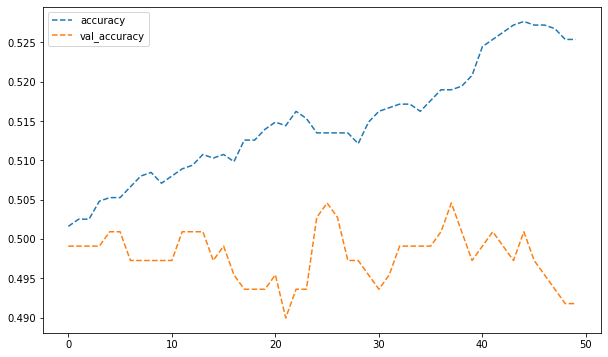

In [159]:
#-----------------------------------------------------------
# Precisão do classificador LSTM nos dados de treinamento e validação por etapa de treinamento
#-----------------------------------------------------------

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [160]:
model.evaluate(X_train, training_data['direction'])

86/86 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5172


[0.69257652759552, 0.5171909332275391]

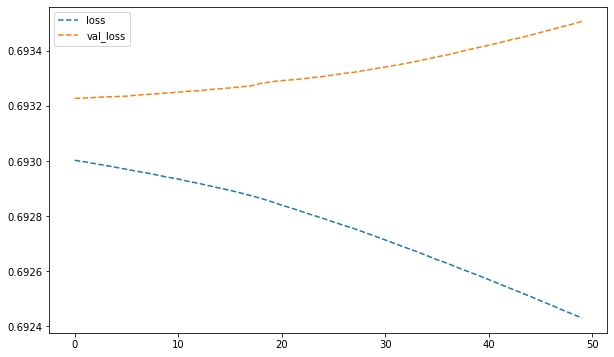

In [161]:
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');

# Matriz de Confusão

#one: 2727
#two: 2914


one = 0
two = 0 


for data in data['direction']:
    if data == 1:
        one+=1
    elif data == 0:
        two+=1

print(one)
print(two)